### Training and Testing of the Baseline and HNN Models on a Spring-Mass System

In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from baseline_models import BaselineMLP
from hnn import HNN 
from utils import L2Loss, rk4

In [3]:
import utils 
print(dir(utils))

['L2Loss', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'np', 'rk4', 'scipy', 'solve_ivp']


In [4]:
from data import get_dataset 

### Which Loss Function to choose for this? 

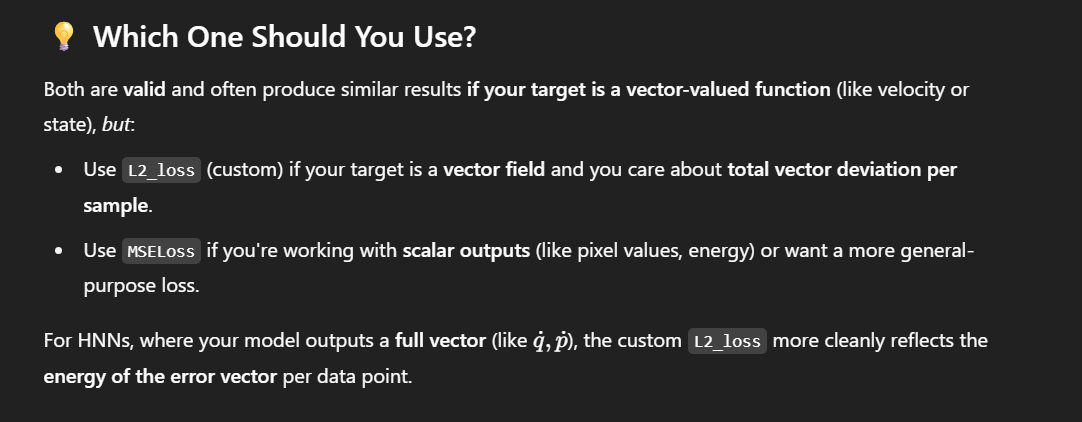

In [5]:


torch.manual_seed(42)
np.random.seed(42)

#according to the paper and my intuition, initializing the model and optimizer
input_dim = 2
hidden_dim = 200 
output_dim = 2 

nn_model = BaselineMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)
model = HNN(input_dim=input_dim, differentiable_model=nn_model)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)



In [6]:
#arranging the data and turning them to tensors 
data = get_dataset(seed=42)
x_train = torch.tensor(data['train_x'], requires_grad=True, dtype=torch.float32) #z = [q p]
x_test = torch.tensor(data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt_train = torch.Tensor(data['train_dx']) #z' = [q' p']
dxdt_test= torch.Tensor(data['test_dx'])

#for the step size dt,
# dt is the timestep used in RK4 integration.
# It should match the spacing in t_eval: dt = t_eval[1] - t_eval[0]
# For example, if t_eval = np.linspace(0, 3, 30), then dt = 3 / 29 ≈ 0.1034
# Use the same dt in RK4 to ensure consistency with trajectory data.

h = 0.1034


In [ ]:
x_train.shape, dxdt_train.shape



(torch.Size([750, 2]), torch.Size([50, 2, 30]))

torch.Size([3000])

In [9]:
#normal training loop
stats = {'train_loss':[], 'test_loss':[]}

epochs = 2000 
for epoch in range(epochs):

    model.train()

    dxdt_hat_train = model.time_derivative(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)

    optim.zero_grad()

    train_loss.backward()

    optim.step()

    #testing 
    model.eval()
    with torch.inference_mode():
        dxdt_hat_test = model.time_derivative(x_test) 
        test_loss = L2Loss(dxdt_hat_test, dxdt_test)
    
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")
    

RuntimeError: The size of tensor a (30) must match the size of tensor b (2) at non-singleton dimension 2